# Chapter 16: Text Representations and Word Embeddings
### Roman Egger
##### <italic>Salzburg University of Applied Sciences - Department: Innovation and Management in Tourism</italic>

---

In this Jupyter Notebook, we will use a number of techniques to create word vectors. We start with One Hot Encoding and Bag of Words, will apply TF-IDF and move on to more complex and powerful techniques like Word2Vec, ELMO and BERT

In [1]:
# if using google colab uncomment these lines to upload the data files 
# airbnb_total.ext, vectors_tourist_cities.txt, vectors_countries.txt, and the helper file ch16.py

# from google.colab import files
# uploaded = files.upload()

Saving vectors_tourist_cities.txt to vectors_tourist_cities (1).txt
Saving vectors_countries.txt to vectors_countries (1).txt
Saving airbnb_total.txt to airbnb_total (1).txt
Saving ch16.py to ch16 (2).py


In [2]:

! pip install numpy
! pip install pandas
! pip install -U nltk
! pip install -U scikit-learn
! pip install -U gensim
! pip install --upgrade tensorflow-hub
! pip install pytorch-transformers
! pip install torch
! pip install spacy
! pip install nlp
! pip install python-Levenshtein
! pip install matplotlib
! pip install wheel
! pip install glove-python-binary
! pip install delayed 



Requirement already up-to-date: nltk in /usr/local/lib/python3.7/dist-packages (3.6.2)
Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
Requirement already up-to-date: gensim in /usr/local/lib/python3.7/dist-packages (4.0.1)
Requirement already up-to-date: tensorflow-hub in /usr/local/lib/python3.7/dist-packages (0.12.0)


In [2]:
# if using google colab, the kernel should be restarted here if modules were isntalled for the first time
# otherwise you may see errors like "can't import name delayed"


In [3]:
import ch16


import sys
import urllib.request
import os

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import nltk
import sklearn
from sklearn.manifold import TSNE
import gensim
import tensorflow as tf
import tensorflow_hub as hub
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel
import torch
import spacy
import nlp

In [ ]:
ch16.check_versions()

python 3.8 (✓)
numpy 1.19.5(✓)
pandas 1.2.4(✓)
nltk 3.6.2(✓)
sklearn 0.24.2(✓)
gensim 4.0.1(✓)
tensorflow 2.5.0(✓)
tensorflow_hub 0.12.0(✓)
pytorch_transformers 1.2.0(✓)
pytorch 1.8.1+cu102(✓)
spacy 3.0.6(✓)
nlp 0.4.0(✓)


We start by using some random sentences from the Airbnb-Dataset (see chapter 1

In [4]:
# use randomly chosen lines from airbnb descriptions

tourism_samples = ['Then the final tasting will introduce you to famous Champagne Houses such as Taittinger and Drappier Cozy in a friendly wine shop of Saint Germain you will taste all the products collected during the tour paired with Champagne']
tourism_samples1 = ['We begin our adventure in the capital of this magical country starting from the square of the sun and we will walk taking beautiful photographs through the most important monuments until we reach our final destination The Royal Palace ', 'Lastly we will walk talk eat maybe munch some more drink of course/claro que si walk talk some more enjoy our time together and sadly say goodbye   We ll explore a few tapas bars at Salamanca neighborhood the place to avoid touristic traps and enjoy a trendy area where local residents gather & socialize ',  'Because of its artistic history and beautiful church on top of the hill Montmartre is called the most attractive tourist destination in Paris since the beginning of th Century It is also one of the most popular places for the young street artists to express themselves and be seen ', ' All our hiking tours start next to the tiger statue in front of the Oslo Visitor Centre at Jernbanetorget in central Oslo Most buses subways trams and trains stops at Jernbanetorget ', 'First we ll meet at one of our favorite spots a lovely teahouse in the Vondelpark which is loved by locals We ll have a drink and a chat about the plans for your shoot Feel free to share your ideas with us and let s be creative together  Then we will take some pictures at some hidden spots in the park After that we ll take a stroll over the iconic canals stopping at various romantic spots and bridges and then head for the lovely Jordaan area with its historical architecture for some more photo in its small streets away from the touristic places  At the end of the photoshoot we ll have a drink and a small food tasting with typical Dutch snacks in a nice little café that dates back to and is located on a quiet canal in the heart of the Jordaan  Within hours we will provide you with at least professionally shot and edited HD pictures through Wetransfer or USB This way you ll have beautiful memories and new stories to take home with you   At the weekends we love to go for brunch with friends Simply because sometimes we want to stay in bed a little longer than breakfast time and it is actually just too early for lunch ', 'After picking you up at your hotel your st stop on the way hour drive to Bohemia wine region is the only Czech winery awarded with DEMETER biodynamic certification You ll be welcomed by local sommelier He ll give a brief introduction of the winery & biodynamic wine production followed by a cellar tour He ll conduct the wine tasting in the winery ', 'Pinecone courtyard Pius Clementine Museum Cabinet of Masks exclusive entrance  gallery of Candelabras gallery of Tapestries Gallery of Maps Sistine Chapel St Peter']
tourism_samples2 = [" The most awaited Warsaw attraction has become a fact it's amazing that when you're visiting Warsaw you can see the place you're looking at most in Poland you do not need to search for bus connections or use trains anymore despite the large number of kilometers in a comfortable way you will be able to experience and see one of the most beloved historical places in Poland Full day tour from Warsaw to Auschwitz and Birkenau camps You will be picked up from your apartment in Warsaw by me and first we will visit Auschwitz Nazi Concentration Camp including also Birkenau Camp Then you will be transfered to a local restaurant for lunch in Auschwitz or Kraków After the tour you will back to Warsaw on the evening We will Travel by comfortable car Volvo xc Mercedes ML or WV", '  Regardless if you have been windsurfing before or not you will improve your skills on this intense course With the power from the wind you will slide thru the water silently', "    We're on winter break until March To request a tour before then send me a private message ", '    Passeio de bike de h em Português bicicleta inclusa ', "       > Then the final tasting will introduce you to famous Champagne Houses such as Taittinger and Drappier Cozy in a friendly wine shop of Saint Germain you will taste all the products collected during the tour paired with Champagne   Follow the footsteps of your favorite Les Miserables characters through charming and historic Parisian neighborhoods with my passionate narration it's as if we’ll see Marius and Cosette falling in love in the Luxembourg garden the ABC club fighting on the barricade Jean Valjean running from one neighborhood to another to escape Javert Thénardier roaming the sewers "]
tourism_samples3 = ['Once you arrive at our place we have a cup of coffee or another drink for you and of course a Dutch snack Then we will explain how to use the SUP stand up paddling board or canoe After that we will ride together through the beautiful nature Stop wherever you want to take a picture or have a closer look at birds trees or plants Each adventure is unique because of you We will take into account all your wishes ', "   Explore the Stockholm Archipelago and its more than islands on a guided tour From sandy beaches rocky shores to forests this is something you can’t afford to miss Before heading into your Kayak you get some basic paddling techniques and safety information Afterward you're ready to paddle into the Archipelago and to encounter many islands on your way Before you get too tired have a break on one of the small islands and prepare some organic lunch On your way back you get to enjoy another organic coffee break ", "  Our Night out are a combination of a party and a bar tour After checking in at our start time you'll grab a drink and meet the group for the evening We then move as a group from venue to venue in total on a route that has been carefully crafted in advance Every unique spot we visit offers the crawl exclusive drink specials and/or free entry st stop free shot discount on fusion cocktails/ nd stop open bar beer &sangria/ rd stop free shot and alot of dance ", "  When I travel I'm always interested in the local music scene But since it's not always easy for you tourists to find out more about that I created this experience ", '   This very distinctive tour will immerse you in the Jewish heritage of Prague focusing on the history traditions legends that were central to Jewish life As a young Czech historian and journalist I will take you to important areas of the city that were essential to the Nazi occupation and the Holocaust On our walk through the Jewish Quarter we will visit the forgotten departure lounge from which Czech Jewish were placed on train transports to the Nazi death camps In addition we will step into the th Century and tour the Jewish district which at that time was the largest Jewish ghetto in Europe The tour will spotlight the life and writings Franz Kafka Our walk through the Jewish quarter will take us to the magnificent Prague synagogue We will pass by the house in which Franz Kafka was born We will visit the New Jewish Cemetery where Kafka is buried ', '   Eco friendly tour operator\u200b Nature hike with an experienced outdoor guide Learn how to start a campfire Try spotting wildlife Swim in Swedish lakes Escape the city life in Stockholm’s best kept secret  % Organic campfire cooked lunch % Organic Swedish Fika with lunch Vegetarian Vegan and Gluten Free options are available  An average of – people per tour max persons  Approximately – km distance  We are always going somewhere doing something ', '   This is the perfect activity for a hot summer day Combining an easy hike with a bath in the crystal clear mountain river ', "  You'll embark the antique saloon boat Delphine in the city centre at the Rijksmuseum dock We will set sail for an early morning experience see the th Century Amsterdam canal area in its quiet hours We’ll have a short stop to retrieve some fresh haring You will enjoy a classic Dutch breakfast I will explain the tradition of the artisan ingredients their origin and specific qualities ", " This is an extensive half day Vienna adventure that covers and combines a multitude of topics a holistic experience for your mind and your senses handcrafted by a native Viennese who knows his city by heart that will immerse you in the culture and history of Vienna's past and present as well as the special atmosphere of this vibrant metropolis in the middle of Europe Besides getting to know the cultural and historical highlights in and around the Inner City a world heritage site you will also experience my favorite places and secret routes that lead us through historic and contemporary Vienna ", ' Join me and my canine friends as we discover the forests and lakes of the Grunewald I am a professional dog walker and I invite you explore this beautiful part of Berlin with my pack a group of dogs big and small confident and sensitive As we walk we can observe how dogs communicate working playing quarrelling and making friends ']                   
tourism_samples4 = ['  We will explore the jungle of my neighbourhood Lavapiés ', " Let's walk together through the History starting from the ancient Roman amphitheatre and ending up in the oldest parisian public library unknown to tourists We will pass by the Pantheon and Sorbonne University and some famous cafés We will visit the magnificent Luxembourg Garden the oldest Saint Germain des Prés church There will be a sweat break in the middle of our walking tour I will offer you a delicious french treat from one of the most eminent pastry chefs ", " We will meet in a traditional Dutch canal caffe 'T Smalle for a coffee and get to know each other better to see who is looking for what I will give the map with my selected vintage spots so that later on you will be able to discover more on your own ", "  https //behrads com @behradsphotography  I’ll guide you in a lively exposition of the cultural religious and historical aspects of the roman civilization through the symbolism and the meanings of the ancient masterpieces I can introduce you to some of the richest collections as the ones of Massimo and Altemps Palaces Capitoline Barracco Etruscan Montemartini Trajan’s Market and Palatine museums The most fascinating locations Baths of Caracalla and Diocletian Stadium of Domitian Piazza Navona to date The Pantheon Colosseum both Roman and Imperial Forum Palatine and Pincian Hills Altar of the Augustan Peace and Mausoleum of Hadrian Castel Sant’Angelo to date The route of the tour is customizable starting from a chosen location then I’ll propose a high quality foot and food tour through the main points selected Special additions will be reserved for restaurants and an exclusive passage into an inner area of the St Peter's Basilica ", ' First of all i will teach you how to make greek phylo which is the basic yeast for all greek pies You are going to make it also by yourself So you will have the chance to create the pie of your preferance The most famous pies from which you can choose is spinach or leek pie cheese pie meet pie trachanas pie  I would be responsible to provide you all necessary ingredients all packed and fresh as i bought them one day earlier than your visit from the local market  At the end you will enjoy fresh fruits and traditional homade greek dessert   This is a private experiense ', '    This three hour flat terrain bike ride leaving from our office takes you to the most famous sights surrounding the Old Town ', '     Learn how to make traditional crêpes get tips on French historical cooking and restaurants in Paris and indulge in a homemade traditional French breakfast made by a chef in a luxurious flat located in the heart of historical Paris ', "  We will meet at PM at 'Kaffe Kirsche' Böckhstraße Berlin Germany near to the Subway Station U Schönleinstraße grab a coffe and start the tour You'll see Kreuzberg's and Neukölln's coolest local designer atelies showrooms green/upcycle/vintage fashion stores and many more I'll also gladly provide more suggestions for your own discoveries by choosing things that match your style/body/budget ", '      I’m offering a nice photoshoot and fun walk through my favorite spots while I capture the best memories of your day You can decide the mood I specialize in lifestyle portrait fashion food and couple photography ', "  learn how to wedge clay properly center it on the wheel get to know basic potter's tools  make your first simple cylindrical shapes depending on your progress we can also try making small bowls yay    I invite you for a degustation of polish local food products You will have a chance to try best polish cold cuts and starters that our country is famous from ", "     All roads lead to Rome If Roman roads are so famous the Ancient Appian Way is the Queen of the Roman Roads and you'll see it exactly as it was years ago First we will meet at the Bar and have a coffee before we start Than we'll bike through a park to the most ancient Roman road the Appian Way with glimpses of rare beauty and get to the ancient Roman Aqueducts immersed in typical Mediterranean nature The ride is relaxing with many stops the pace is slow you get to see Rome off the beaten path enjoying the surprising beauty of mother nature and ancient ruins just a few kilometers apart from the hustle and bustle of the city center So GET READY TO RIDE FOR ALMOST KM MILES through some of the city’s most unique sightseeing discover hidden spots in nature see some of the unknown gems of Rome and get back to your place with perfect pictures During the ride you'll also taste typical flavours of a Roman appetizer ", " Show your followers something new discover a park not famous among tourists but beloved by the locals Madrid Rio a preserved green area with amazing landscapes and architectural interventions like metal bridges greenhouses artificial beach a cultural center and more A relic hidden right in the middle of the city  Real moment photos you don't have to worry about posing our style focuses on capturing real lifestyle moments with an editorial touch which is exactly what people are looking for in digital influencers right now  Photos that tells a story you'll receive all the photos taken from the experience edited and in high quality already delivered in formats suitable for social media like Instagram Stories vertical photos and Facebook cover  Receive the digital version of my book Influence Marketing for Digital Influencers with end to end tips on how to be successful in this field through marketing techniques    We meet in a special and very old shop of alpargatas tipical spanish shoes were the visitor can know the history of this items and also buy for very cheap price ", '    I charge Swedish Krona per edit for fully retouched photographs in addition to the fixed photographs included   My studio is on the second floor of the apartment After entering our studio we first visited our experience site and a fresh artistic atmosphere came to us There are many easels abundant sunshine by the window good lighting and high popularity Then we will talk about the introduction of painting and how to learn painting We personally demonstrated the method of drawing taught you the basic skills of sketch and then you slowly practice and speculate ', " Join us for a one of a kind experience in our beautiful city We'll start off with a quick meet and greet and then jump right into our kayaks to start our adventure We will begin in central Prague right by the Charles bridge and start paddling through the Vltava River Throughout our trip we will show you some of the most beautiful historical monuments and locations in Prague including kayaking under the Charles Bridge riding alongside the seat of the Government of the Czech Republic and getting an amazing view of Prague Castle ", '   Windmill next to the Brewery t`IJ Museum square Central train station NEMO Science museum Dam square Nieuwmarkt area Prinsengracht  The Coffee Educators host a full coffee training workshop from bean to cup Using locally roasted beans from around the world We will explore the tasting profiles of coffee You will learn how the origin of coffee beans directly impact the final flavour You will learn how the different methods that are used to process coffee elevation and roast profiles impact the final product ', "      Moulin Rouge Cabaret and the Red light district  Ateliers and homes of great artists Picasso Van Gogh Renoir Toulouse Lautrec Movie spots from 'Amélie' among others films Square des Abbesses and the romantic 'I love you' wall  The last windmills and beautiful vineyards  We'll find out one of the oldest Parisian church a former abbey We'll finish discovering the Artists Square Place du Tertre and the beautiful Basilica of the Sacred Heart where we'll get fabulous views of the Parisian rooftops   We will meet at my studio in Sèvres Babylone We will start by Colorimetry test The color analysis reveals which color pallets most brighten your natural assets complexion skin tone and body type ", '  Step by step guide in hours ', " Our Experience as Guide who know the city Streets and it's Best Spots will Guide you through some of The Best Bars    The aim of the tour is to provide an unforgettable experience We drive southeast of the city along the coastal road passing by wonderful beaches so we have a taste of the Athenian Riviera On the way we have a splendid view of the Saronic Gulf and the isles offshore Our first stop ' ' for amazing photos or/and swim at the Vouliagmeni Lake the hidden treasure of Attica's nature Situated on an idyllic landscape this rare geological phenomenon welcomes you The water is half gushes from springs to m deep and half from the sea and its temperature is between degrees Celsius throughout the year With entrance fee € you can also enjoy a thermal spa experience in the brackish waters constantly recycled rich in salts and minerals Also there is a fish spa by the Garra Rufa spa fish ", ' Easter wreath workshop You will learn how to create two amazing eater wreaths for hanging in the doorway and for a beautiful table setting You will learn two different techniques and we will work with foliage and flowers ', " This Segway's route will allow you to discover importants points of interests in Paris all in just hour ", '  We will experience the streets of the historical Madrid in a very original way as while we will pass by both the most iconic places in the capital and exclusive streets and secret alleys you will get an unforgettable portrait picture I will make sure I will shoot memorable photos of you in each special spot and deliver my photos after the experience via email so that you can remember your time in Madrid forever ', ' This experience is about visiting some royal parks eclectic architecture and Laken cemetery it is the oldest cemetery which is a funeral art museum open to the public daily to Together we will look at the craft art of sculptors and try to seek the signs of life and death cycle Every tomb might tell a story We will take some time and space together to interpret it At some of the tombs I will introduce a historical biographical note ', "         From our meeting point Via degli Annibaldi that is a stone's throw from Cavour metro station in a few pedal strokes with our e bikes we'll reach the Campidoglio hill to enjoy the most astonishing sunrise you can see in Rome Then our ride we'll bring us to see the most panoramic spots in Rome the sunlight is magic in the morning and gives Rome incredible colours The city is still asleep so this will be the best moment to enjoy also the most tourist places with no stress feeling the sensation of having the beauty of Rome all for you ", " We'll meet at the Thiseio Metro exit Marley and myself we'll wait for you outside We'll visit the hill of Pnyx to enjoy the fantastic view of Acropolis and Parthenon We will walk in Plaka and the picturesque neighborhood of Anafiotika Time permitting we will visit some special places of Athens not known to tourists All this time I will tell you about the history of Athens and Greece and I will take photos of you with Marley ", ' We will walk as a group over the less crowded routes chatting and taking pictures on the spots I have selected as both original and interesting places suggestions and little changes are welcomed too I take extra care of giving everyone the same attention while giving you possing tips and correct any mistakes so you get the best possible pictures on all spots The idea is to leave the place with fashion grade pictures of you having fun in Paris ', "         The Musée d'Orsay contains the world's biggest collection of Impressionist art Nearly one out of three Impressionist paintings exhibited in museums all over the world are in this building a beautiful former railway station built for the Universal Exhibition of transformed in museum in ", '     Classic italian aperitif Spritz Original americano drink and classic Milano Torino Elegant Martini Cocktail Traditional cuban mojito  From the centre to suburbs on the off beaten path we will visit places connected by the giant murals They are the leading thread of this itinerary which is much more than a murals’ tour Social aspects history architecture anecdotes about Rome and a bit of culinary make the experience much more appealing and complete to understand some aspect of the Italian culture ', '       Morning class \u200b coffee/wine around h pm   You will take steps down then all the way up ', " It's a breakfast walk to remember filled with slices of life history architecture + current events w/ a passionate local food guide writer/researcher We zigzag past Paris' most historic buildings tour it's oldest neighborhoods over charming canals I'll guide you through Paris' most beloved covered marche marche closed monday A leisurely morning w/ stops along the famed Canal St Martin commissioned by Napoleon and in charming manicured gardens in the historic district le Marais to enjoy our treats in the shade We stroll past in the know places to return to for shopping dinner drinks and you'll leave with an excerpt of the Paris is Burning Guide to how to visit Paris like you live here  We end relaxing in one of Paris' oldest/most scandalous buildings w/ coffee by the first female roaster to win the prestigious Meilleur Torrefacteur de France  We offer you a unique experience in Paris a voyage to the heart of the most emblematic musical instrument in France the ACCORDION ", '  the classic dry white of the Loire Valley with its iconic “chèvre” Germany’s Riesling – maybe the world’s best cheese wine – as it enlivens the piquant raw milk Allgäuer Bergkäse from the Alps a gorgeous Austrian rosé paired with a cheesy garlicy dip Piedmont’s world famous elegant red wine along with the Taleggio “tired cow” cheese that complements it so well the sumptuous fruity Spanish combination of sun kissed reds with aged Manchego and of course we will taste how Port from the Duoro is improved by tangy salty ewe’s blue cheese  Come walk through Kreuzberg and Friedrichshain with me your passionate and enthusiastic guide as we cross the city to visit major alternative sights on the eastern side of Berlin ', "          Couple week end Family time or even solo traveller how often have you visited a city and only walked away with photos of what you ate or pixelated smartphone selfies Let's change that I am a photographer so you're at the right place ", ' Je propose depuis ans une offre adaptée à chaques groupe je viens vous récupérer devant votre appartement ou hôtel et nous découvrons un bout de la ville ensemble et du quartier du restaurant je dois être en relation avec une bonne ene d’autres eux ', ' We’ll hit the streets of Paris seeking out the most beautiful landmarks & hidden locations We will start the session early morning to avoid the crowds However if you would prefer a specific time slot it is also possible The session will take place in a relaxed atmosphere & I will guide you on different poses and positions so no previous experience in front of the camera is necessary Within days I will send you the very best images that have been edited to perfection after the shoot You should expect to receive between fully edited photographs ', ' Join me for this historic walk through Amsterdam and learn all about Anne Frank during the Second World War I will meet you at Waterlooplein and from there we will discover the most important sights about Anne Frank and other Jews during World War We will explore my favorite district in Amsterdam The Jewish Quarter where we will pass the Portuguese Synagogue and the Jewish Council headquarters Together we will discover historical monuments and buildings which are still marked by traces of war ', '  If you want to know what it feels like walking around athens with a passionate local come and join me When feeling like strolling around in my home town i have my favourite route ', ' We will meet at Trocadero and we will take you to a one hour tour of the neighborhood We will have a great time taking pictures in hidden streets near the Eiffel Tower who are not knowed by the tourists ', " My tour will take us to of the best vegan restaurants in the area of Oud West The walk from restaurant to restaurant allows us to sightsee streets like Jan Pieter Heijestraat Kinkerstraat and Overtoom the gorgeous area above Vondelpark During those walks as well we will chat about history culture our local experience or just about any vegan topic that may come up It will be a fun time that's for sure ", ' Welcome to a city tour through the journey of Amsterdam flea markets ', '   Get to know/see/taste  Amsterdam like a local  ENJOY THE FOOOOOOD  the amazing foodspots To get from A to B we need the bicycle  how it feels to ride on a bike along the beautiful canals  different neigbourhoods  the beautiful hidden gems that Amsterdam has to offer  the highlights architecture and houses of Amsterdam  typical and delicious Dutch treats  your way to the most popular restaurants bars shops hotspots  hangouts in Amsterdam  a lot more    Trip Itinerary semi private tour approximately hours ', '           You have tried the doner and Currywurst and have seen the touristy spots like Brandenburg Gate and Checkpoint Charly You want to explore the alternative and underground side of Berlin and also want to grab some food coffee and even a shot on the way Then my all new package tour might be just the right thing for you ', '  This is a unique wine tasting and bike tour Experience ', '  There’s nothing like night photography The magical feeling you get when you nail a breathtaking long exposure never gets old ', ' Relax and enjoy the feeling of the celebrities where you will walk in the historical streets of Vienna while I am your own photographer who is capturing the beautiful moments and the best memories from your Vienna Visit ', " I truly believe that Warsaw is one of the most unique place on earth but it's uniquness is not always visible around It is something that comes with understanding Therefore I would like to invite you not only to explore Warsaw with me but also to understand it We will walk around the Old Town to experience city at it's glory but also to find examples of the most uniqe post war reconstruction which is the reason for placing Warsaw on UNESCO Heritage site Monuments and memorials will let you understand tragic times of WW including Jewish ghetto and Warsaw Uprising history We will check if undestroyed Praga is really so dangerous as people say and you will get to know the most famous Warsaw's inhabitants And of course there will be space for unusual spots and Warsaw's hidden gems ", ' Discover authentic Spanish food alongside a hour fun and dynamic explanation of the history of Madrid stopping at three traditional tapas bars for some delicious wine beer sangria with an assortment of tapas such as croquetas Spanish ham Manchego cheese chorizo tortilla and paella finishing off with some traditional Castilian after dinner shots I will also be delighted to give you recommendations of what to do for the rest of your stay ', '     We will meet under the Water Tower near Cafe Restaurant Amsterdam I live right around the corner and will tell you a little about the neighborhood After that we will take minutes to make sure everyone is comfortable on their bike ', '   We will start with a light warm up of some jogging and active stretching usually followed by some games and partner work to get ready for the workout minutes ', ' Starting point from Place de Concorde one of my favourite spots in the city of love thanks to its overwhelming monuments e g Oblélisque de Louxor  From there we will walk through jardin des Tuileries to Musée du Louvre an architechural masterpiece  We will cross Cité island the cradle of Paris and end up in Saint Michel with its beautiful Notre Dame  I will do my best to teach you about Paris history and French language when I can  NOT YOUR BASIC FOOD TOUR All food is included ️', '                   Imagine an alternative present a world of coal and steel where monocled archaeologists rend the ground with blackened steam shovels and clock work automata sift through marble fragments of gods and emperors in search of forgotten treasures ', "     The pictures will be delivered in / days on your email throught the website Wetransfer The website provide a service to deliver multiple pictures all at once You will receive an email from Wetransfer with a link inside to download the pics The link will expire in days  I will teach you how to make many types of homemade pasta in a real laboratory of pasta reviewed on the prestigious Il Gambero Rosso guide from We will start with handmade pasta made with different kind of grains like ancient grain Triticum Monococcum considered the first cereal cultivated by man around BC Senatore Cappelli created by Nazareno Strampelli on this grain disappear in the ' and arrived to the present days thanks to some small farmers and the gluten free flour Grano Saraceno buckwheat We will do thin sheets dough also colored in green with spinach or brown with sour cocoa explanation of safe food cutting procedures realization of three types of ravioli fettuccine one tipical italian sauce like Simple sauce Besciamella Carbonara Cacio e Pepe or Gricia sauce and one vegan type of pasta without egg We can also accomodate gluten free allergy guests for a very tasty GLUTEN FREE FRESH PASTA "]

In [5]:
# One Hot Encoding
import pandas as pd

data = "Information is the lifeblood of Tourism"
words = data.split(" ")
uniqueWords = list(set(words))
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)
encoded = pd.get_dummies(uniqueWords)
print(encoded)

   Information  Tourism  is  lifeblood  of  the
0            0        0   1          0   0    0
1            0        0   0          0   0    1
2            0        0   0          0   1    0
3            1        0   0          0   0    0
4            0        1   0          0   0    0
5            0        0   0          1   0    0


In [8]:
# Bag of Words
import nltk

sentence1=["This hotel is a city hotel and it is located in the city center of Salzburg."]

# uncomment the following line if you get an error "resource stopwords not found" 
nltk.download('stopwords')
# uncomment the following line if you get an error "resource punkt not found" 
nltk.download('punkt')

from nltk.corpus import stopwords
    
from nltk.tokenize import word_tokenize

text = "this hotel is a city hotel and it is located in the city center of Salzburg."
text_tokens = word_tokenize(text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

print(tokens_without_sw)
print(text_tokens)

['city', 'located', 'city', 'center', 'Salzburg', '.']
['this', 'hotel', 'is', 'a', 'city', 'hotel', 'and', 'it', 'is', 'located', 'in', 'the', 'city', 'center', 'of', 'Salzburg', '.']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
# TF-IDF
# https://medium.com/analytics-vidhya/a-beginners-guide-to-natural-language-processing-part-4-734b995c53ea

from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# text for which we are making vectors
corpus = ["information is the lifeblood of tourism", "the internet altered the tourism industry"]

# initialize TV object
tv = TfidfVectorizer()

# fit trains the object to obtain the vocabulary.
# transform converts the text into vectors
tf_vects = tv.fit_transform(corpus)

# column names are unique words or bigrams/phrases or even entire documents
tv.get_feature_names()

# convert to a dataframe to display
tf_vect_df = pd.DataFrame(tf_vects.todense(), columns=tv.get_feature_names())
tf_vects.toarray()
# array([[0.52284231, 0.        , 0.        , 0.67325467, 0.52284231, 0.        ],
#       [0.29903422, 0.385061  , 0.50630894, 0.385061  , 0.59806843, 0.        ],
#       [0.32401895, 0.4172334 , 0.        , 0.        , 0.64803791, 0.54861178]])

tf_vect_df

,altered,industry,information,internet,is,lifeblood,of,the,tourism
0,0.000000,0.000000,0.446656,0.000000,0.446656,0.446656,0.446656,0.317800,0.317800
1,0.425196,0.425196,0.000000,0.425196,0.000000,0.000000,0.000000,0.605061,0.302531


In [11]:
# Word2vec
# https://medium.com/analytics-vidhya/a-beginners-guide-to-natural-language-processing-part-5-10709cdc1d34
# https://towardsdatascience.com/word-embeddings-exploration-explanation-and-exploitation-with-code-in-python-5dac99d5d795
    
# uncomment the following line if you get an error "resource punkt not found" 
# nltk.download('punkt')

# import the training model
from gensim.models import Word2Vec
# import the scoring metric
from sklearn.metrics.pairwise import cosine_similarity

# processed data as a list
list_of_strings = ['the internet altered the tourism industry', 'information is the lifeblood of tourism', 'people like to travel in summer']
# making the sentences into tokens
all_words = [nltk.word_tokenize(sent) for sent in list_of_strings]

# training the model
# since we have a very small corpus, we take a small window and min_count
# vector_size is the embedding size
word2vec = Word2Vec(sentences=all_words, min_count=1, vector_size=30, window=2)

# store the vocabulary
vocabulary = word2vec.wv.key_to_index

# get the embeddings of the words
v1 = word2vec.wv['tourism']
v2 = word2vec.wv['travel']
v3 = word2vec.wv['internet']


print(v1)
      
# check similarity of 2 embeddings
cosine_similarity([v1],[v2])
# result
# array([[0.09820592]], dtype=float32)

[-0.02503948 -0.00309923  0.03179422 -0.02439745 -0.00777907 -0.0064599
  0.02692479 -0.01976895  0.00015144 -0.01584692 -0.0320114   0.01669125
 -0.02919874 -0.01463991 -0.00011661 -0.00098758 -0.02553702  0.032049
  0.01660642  0.030778   -0.02719328  0.0149859  -0.01378915  0.00274967
  0.02832836 -0.01487381  0.01505885 -0.02262343 -0.01182844  0.03132877]


array([[-0.00080314]], dtype=float32)

# ELMO

In [12]:
# ELMO
# https://medium.com/analytics-vidhya/a-step-by-step-nlp-guide-to-learn-elmo-for-extracting-features-from-text-de0d77e32a99
# https://github.com/PrashantRanjan09/Elmo-Tutorial/blob/master/Elmo_tutorial.ipynb
# https://towardsdatascience.com/elmo-contextual-language-embedding-335de2268604

import tensorflow_hub as hub 
# import tensorflow as tf 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

 
# downloading the pretrained model
# if you get an error saying that the name is already in use, change 'elmo_module1' to somthing else 
elmo = hub.Module("https://tfhub.dev/google/elmo/3", trainable=True, name='elmo_module1')

# sample input
sample_input = ["Information is the lifeblood of tourism. The internet has altered the tourism industry"]
#sample_input = ["there is a lot of grass on the river bank. The bank is closed during the holidqays"]
sample_input= ['He kicked the bucket.', 'I have yet to cross-off all the items on my bucket list.', 'The bucket was filled with water.']
sample_input = tourism_samples
# getting the output dictionary for the sample
output = elmo(sample_input,
             signature="default",
             as_dict=True)

# getting the embeddings by selecting 'elmo' from the dictionary
embeddings = output['elmo']

embeddings.shape



Instructions for updating:
non-resource variables are not supported in the long term
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


TensorShape([Dimension(1), Dimension(38), Dimension(1024)])

The embedding tensor we get as output is three-dimensional. The first dimension corresponds to the number of samples, the second is the length of the longest string in the input. The third dimension is the vector representation of  the input sample: the ELMo vector. This means that every word in the input has an ELMo vector representation of size 1024.

For the  example text, we get a tensor of shape 1 (1 sample) x 38 (longest text has 38 words) x 1024 (ELMo vector length). 

In [13]:
# get a single vector for a text string (eg. a sentence, but it can also be a longer text)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    # return average of ELMo features
    emb =  sess.run(tf.reduce_mean(embeddings,1))
emb.shape

(1, 1024)

In [14]:
# get tokens (word emnbeddings), labels (words)
# this may take some time
tokens = []
labels = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    for k in range(len(sample_input)):
        for i, word in enumerate(sample_input[k].split()):
            tokens.append(sess.run(embeddings[k][i]))
            labels.append(word)


In [15]:
# reduce dimension and plot the vectors
# directly see similarity between words

def tsne_plot(tokens, labels):
    # see https://github.com/PrashantRanjan09/Elmo-Tutorial/blob/master/Elmo_tutorial.ipynb
    # reduce the dimension of the elmo vectors to 2 so they can be plotted
    data = np.array(tokens)

    tsne_model = TSNE(perplexity=6, n_components=2, init='random', n_iter=500)
    tsne_data = tsne_model.fit_transform(data)
    x = []
    y = []
    for value in tsne_data:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(15, 12)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()    

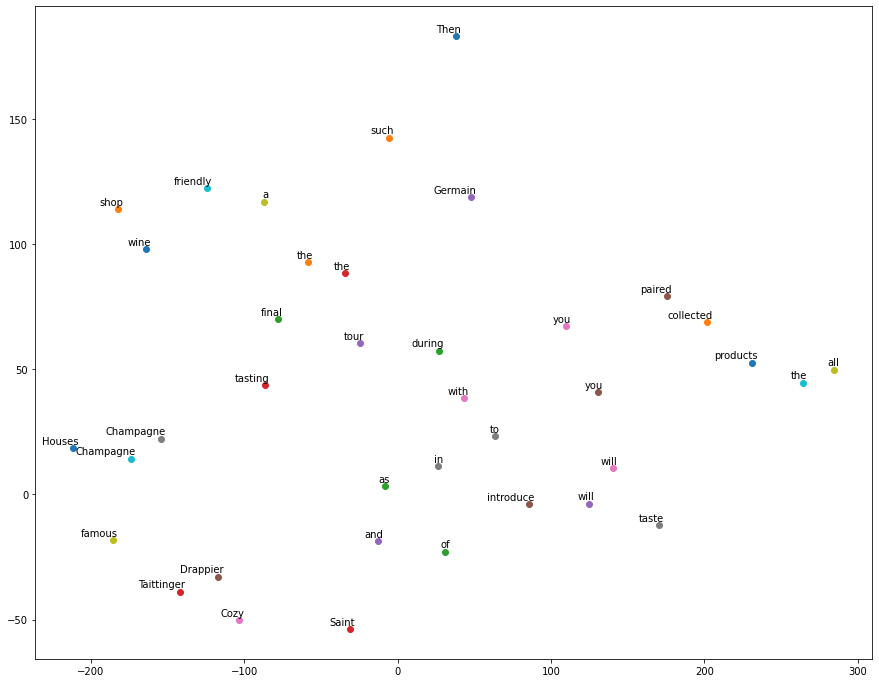

In [16]:
tsne_plot(tokens, labels)

this example demonstrates how even in a very small text sample, groups words with similar context together well.

# Fasttext
see https://towardsdatascience.com/word-embedding-with-word2vec-and-fasttext-a209c1d3e12c

FastText is an extension to Word2Vec. However, unlike Word2Vec, it breaks words into parts called n-grams. For example, the word 'apple' would be broken down into tri-grams: 'app', 'ppl' and 'ple'. The word embedding for 'apple' is then summed from the embeddings of its tri-grams. This has the effect that for rare words, the embeddings are enriched with context, since some of their n-grams will also appear in more frequent words, allowing FastText to use their context as well.  


In [17]:
from gensim.models import FastText
    
# use tourism_samples (list of strings) as text sample
# convert to string
sample_string = ' '.join(tourism_samples4)

# separate words 
sample_text = [[w for w in line.split(' ') if w and not len(w)==0]for line in tourism_samples4 ]
#print(len(sample_text), 'lines')
# 50 lines

# sample_text is now a list of lists of string which contain words 
# train model
model = FastText(sample_text, vector_size=100, window=5, min_count=5, workers=4,sg=1)

#glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')
#model = FastText(sentences_ted, size=100, window=5, min_count=5, workers=4,sg=1)


In [18]:
# find similar words using a word that appears in the training set 

print('traditional' in sample_string)
model.wv.most_similar("traditional")

True


[('different', 0.9999220967292786),
 ('history', 0.9999016523361206),
 ('beautiful', 0.9999011754989624),
 ('historical', 0.9999009966850281),
 ('place', 0.9999001026153564),
 ('discover', 0.9998992085456848),
 ('start', 0.9998990893363953),
 ('experience', 0.9998974204063416),
 ('places', 0.9998962879180908),
 ('Amsterdam', 0.9998939633369446)]

In [19]:
# but wen can also find similar words to words that do not appear in the training set
# dues to the small size of the set, the similar words however have to be drawn the 
# cooking subjects  

print('countryside' in sample_string)
model.wv.most_similar("countryside")
#print(sample_text)

False


[('guide', 0.9988070130348206),
 ('start', 0.9987667798995972),
 ('through', 0.9987577795982361),
 ('ride', 0.9987448453903198),
 ('your', 0.99874347448349),
 ('hidden', 0.9987286329269409),
 ('our', 0.9987218379974365),
 ('Rome', 0.998715877532959),
 ('bike', 0.9987115859985352),
 ('beautiful', 0.99869304895401)]

## GloVe 
Glove means 'Global Vectors for Word Representation'.  It is developed as an open-source project at Stanford University. 'Global' means that the word vector reflects the meaning of the word within the entire corpus. Glove uses word frequency and co-occurence. The resulting vector can be compared to other vectors for word similarity.  

In [20]:
import itertools
from gensim.models.word2vec import Text8Corpus

# this part does not work in windows (glove's Corpus() throws an error)

# using glove_python
from glove import Corpus, Glove

# get file 'text8', (linux commands)
#if not os.path.isfile('text8'):
#    !wget http://mattmahoney.net/dc/text8.zip && unzip text8.zip

# get file 'airbnb_total.txt' from github
#import requests
#url = 'https://raw.githubusercontent.com/mateinfour/chapter16/main/airbnb_total.txt'
#r = requests.get(url, allow_redirects=True)
#with open('file_airbnb_total.txt', 'wb') as f:
#    f.write(r.content)
    
# load file locally ('airbnb_total.txt')           

# use 'text8 or airbnb_total.txt'        
# sentences and corpus from standard library
sentences = list(itertools.islice(Text8Corpus('airbnb_total.txt'),None))
corpus = Corpus()

# training the corpus to generate the co-occurrence matrix used in GloVe
corpus.fit(corpus=sentences, window=10)
#creating a Glove object which uses the co-occurrence matrix to create embeddings
glove = Glove(no_components=100, learning_rate=0.05)

# training the model. this may take quite some time
#if not os.path.isfile('glove.model'):
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
# add dictionary to glove object
glove.add_dictionary(corpus.dictionary)
# saving the model
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


Creating a glove model uses the co-occurrence matrix generated by the Corpus object to create the embeddings.
The corpus.fit method takes two arguments:

corpus — the 2D array input with lines of text

window — the maximum distance between two words to find some relationship between them

In [21]:
# get embeddings for sample text
# this may take some time
input_sample = tourism_samples

tokens = []
labels = []
for sentence in tourism_samples:
    for word in sentence.split(' '):
        #word = word.replace('.', '').lower()
        tokens.append(glove.word_vectors[glove.dictionary[word]])
        labels.append(word)

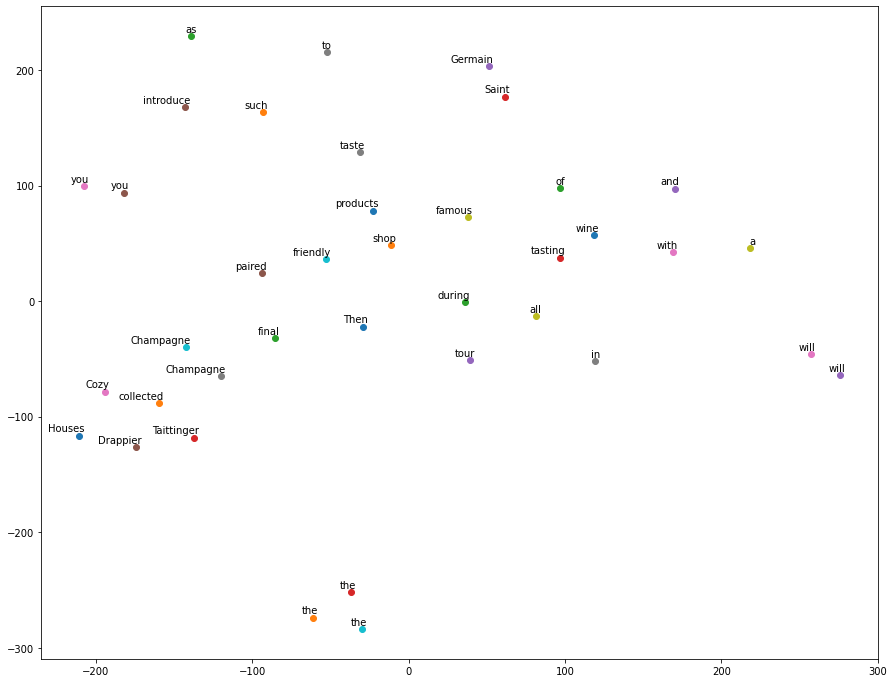

In [22]:
# plot words of sample sentence downprojected to 2D using t-sne 
tsne_plot(tokens, labels)

In [23]:
# BERT

from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel

## Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased',output_hidden_states=True)

# Define a new example sentence with multiple meanings of the word "bank"
text = "Information is the lifeblood of tourism. The internet has altered the tourism industry"

# Add the special tokens.
marked_text = "[CLS] " + text + " [SEP]"

# Split the sentence into tokens.
tokenized_text = tokenizer.tokenize(marked_text)

# Map the token strings to their vocabulary indeces.
indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

# Display the words with their indeces.
for tup in zip(tokenized_text, indexed_tokens):
    print('{:<12} {:>6,}'.format(tup[0], tup[1]))

100%|██████████| 440473133/440473133 [00:10<00:00, 42191169.19B/s]


[CLS]           101
information   2,592
is            2,003
the           1,996
life          2,166
##blood      26,682
of            1,997
tourism       6,813
.             1,012
the           1,996
internet      4,274
has           2,038
altered       8,776
the           1,996
tourism       6,813
industry      3,068
[SEP]           102


In [24]:
import torch

# Convert inputs to PyTorch tensors
tokens_tensor = torch.tensor([indexed_tokens])

# Put the model in "evaluation" mode, meaning feed-forward operation.
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [25]:
# Run the text through BERT, get the output and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = model(tokens_tensor)

    # can use last hidden state as word embeddings
    last_hidden_state = outputs[0]
    word_embed_1 = last_hidden_state

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

    # initial embeddings can be taken from 0th layer of hidden states
    word_embed_2 = hidden_states[0]

    # sum of all hidden states
    word_embed_3 = torch.stack(hidden_states).sum(0)

    # sum of second to last layer
    word_embed_4 = torch.stack(hidden_states[2:]).sum(0) 

    # sum of last four layer
    word_embed_5 = torch.stack(hidden_states[-4:]).sum(0) 

    #concat last four layers
    word_embed_6 = torch.cat([hidden_states[i] for i in [-1,-2,-3,-4]], dim=-1)

In [26]:
word_embed_5

tensor([[[ 0.7243, -1.2354, -0.0534,  ..., -2.1715,  2.0711,  1.8883],
         [-1.4286,  1.9369,  2.2106,  ..., -0.3266,  0.6072, -0.6579],
         [ 0.4992,  1.5606,  2.6297,  ..., -1.0799,  1.9338,  1.1836],
         ...,
         [ 2.8947,  1.6819,  4.9113,  ..., -0.4594,  2.3798, -0.0314],
         [-0.7187,  1.2479,  0.6565,  ..., -2.9043,  3.4472, -1.7060],
         [ 0.4703, -0.0677,  0.4450,  ..., -0.1805, -0.0650, -0.6184]]])

## Playing with text vectors

## GloVe

In [27]:
# download glove.6B.zip from http://nlp.stanford.edu/data/glove.6B.zip 
# the archive contains several files
# extract the archive and place file glove.6B.300d.txt in current directory

# if you want to use the entire glove.6B.300d.txt uncomment the following lines and comment out the
# lines for the city vectors
# embeddings = {}
# if not embeddings:
#    with open('glove.6B.300d.txt') as f:
#          embeddings = {l.split()[0]: np.array(l.split()[1:]).astype('float') for l in f}

# here, we'll use only city vectors
with open('vectors_tourist_cities.txt') as f:
    embeddings = {l.split()[0]: np.array(l.split()[1:]).astype('float') for l in f}

with open('vectors_tourist_cities.txt') as f:
    vectors_tourist_cities = f.read().split('\n')[:-1]
print(f'found vectors for {len(vectors_tourist_cities)} cities')

# look at the first 5 embeddings (and the first 5 dimension of each vector)
for i, (k, v) in enumerate(embeddings.items()):
    print('{} -> {}...'.format(k, v[:5]))
    if i == 5:
        break
#if not os.path.isfile('wiki-news-300d-1M.vec'):
#    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip && unzip "wiki-news-300d-1M.vec.zip"
#if not os.path.isfile('vectors.vec'):
#    pass
#!cat wiki-news-300d-1M.vec | head -n 50001 | tail -n 50000 > vectors.vec


found vectors for 129 cities
washington -> [ 0.033331   -0.10067     0.00043131 -0.17152     0.023796  ]...
london -> [-0.04269 -0.512    0.41169  0.58458  0.11428]...
mexico_city -> [ 0.3      0.80191 -0.72953 -0.42422 -0.27676]...
beijing -> [ 0.069266  0.071872  0.01913  -0.51634   0.031598]...
paris -> [ 0.28199  -0.043577 -0.2124   -0.21808   0.011582]...
atlanta -> [ 0.29485  0.23427 -0.13973  0.14887  0.30857]...


In [28]:
# define a function to calculate euclidean distance between the vectors
# this will serve as similarity measure (the distance is greater when the vectors point farther away from each other)

def get_closest(x, top_k=3):
    """
    Get the closest embeddings calculating the euclidean distance
    x: np.ndarray
    Vector containing an embedding
    top_k: int, optional
    Get the top k similar embeddings
    Returns : Dict containing the top k similar embeddings to the given x
    """
    # Stack all embeddings in a single matrix. Note: the matrix dimension will be
    # V x D where V is the vocabulary size and D is the embedding dimension
    embedding_matrix = np.array(list(embeddings.values()))
    # Using broadcasting to compute distance to each embedding in our vocabulary
    distances = x - embedding_matrix
    # Compute the magnitude (norm) of each distance
    distances = np.linalg.norm(distances, axis=1)
    # Sort distance and keep the smallest k
    min_idx = np.argsort(distances)[:top_k]
    return {list(embeddings)[i]: embedding_matrix[i] for i in min_idx}

In [29]:
# retrieve top 5 similar embeddings for 'paris'
similar_city = get_closest(embeddings['miami'], top_k=5)
print(list(similar_city))

# retrieve top 5 similar embeddings for 'athens'
similar_city2 = get_closest(embeddings['hamburg'], top_k=5)
print(list(similar_city2))

['miami', 'orlando', 'dallas', 'houston', 'chicago']
['hamburg', 'munich', 'berlin', 'frankfurt', 'amsterdam']


this seems to work well. let's look at the vectors and their distance in a 2D plot 

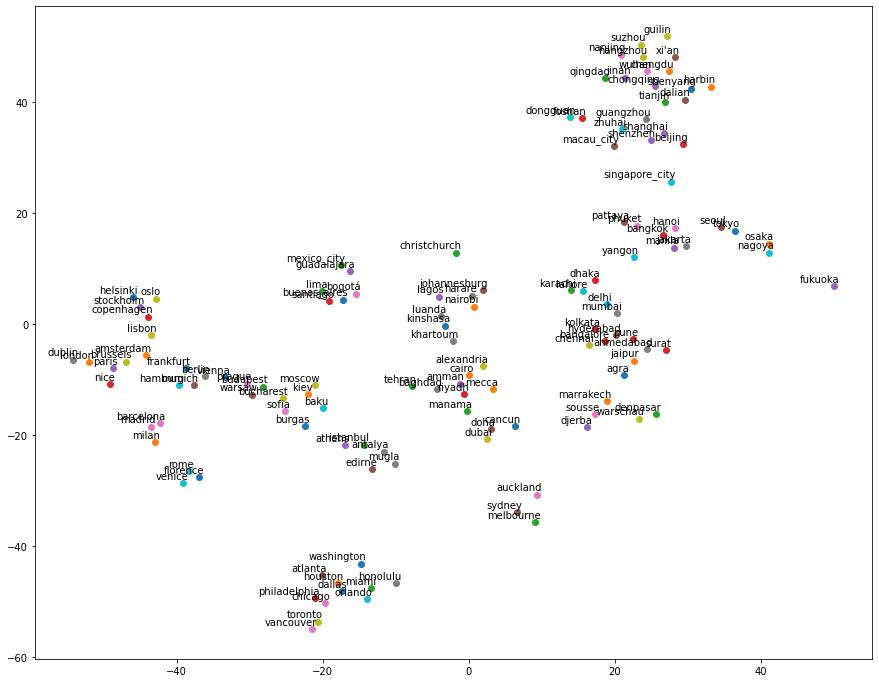

In [31]:
# using dimensionality reduction to plot word clusters

# plot simlar cities 
vectors = []
labels = []
words = similar_city.copy()
words.update(similar_city2)
for word in words:
    vectors.append(words[word])
    labels.append(word)

# plot all cities in list
vectors = []
labels = []
for line in vectors_tourist_cities:
    word = line[:line.index(' ')]
    labels.append(word)
    vector = line[line.index(' '):].split(' ')[1:]
    vector=[float(f) for f in vector]
    vector = np.array(vector)
    vectors.append(vector)

    
tsne_plot(vectors, labels)       

When plotting all cities, the clusters seem to follow geographical location only. While that seems to be a major criterion, clusters for indin and chinese cities are far apart - reflecting a different context despite of close location.

### analogies

In [32]:
# items that are similar are clustered in higher dimensional space, However, also the distances between words
# that have a similar relation- like King-man, Queen-woman- are similar. 
# Therefore, we can try to solve an anaolgy like man-king, woman? -> Queen by using arithmetics:
# we assume that man-king is similar to woman-queen. taking that as an equation man-king=woman-queen, we can resolve it for queen:
# queen = man - king + woman
# lets try that with cities: hamburg is to germany like vienna to ?
 
# add country vectors    
with open('vectors_countries.txt', 'r') as f:
    embeddings_countries = {l.split()[0]: np.array(l.split()[1:]).astype('float') for l in f}

embeddings.update(embeddings_countries)
    
# get vectors
hamburg = embeddings['hamburg']
germany = embeddings['germany']
vienna = embeddings['vienna']
# calculate
city_vector = germany-hamburg+vienna
analog = get_closest(city_vector, top_k=3) 

print(list(analog))



['austria', 'vienna', 'germany']


glove has correctly guessed that vienna is related to austria in a similar way as hamburg is to germany 

## Word2vec

In [33]:
# use Word2Vec to find most similar words
# see https://radimrehurek.com/gensim/models/word2vec.html

from gensim.models import Word2Vec
# import small text example for testing
from gensim.test.utils import common_texts


# create small text sample from tourist_samples4
sample_text = [[w.lower() for w in line.split(' ') if w and len(w)>2] for line in tourism_samples4]

#sentences = common_texts
sentences = sample_text

model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, workers=4)
model.train(sentences, total_examples=model.corpus_count, epochs=2)

# get similar words
word = 'vienna'
vector = model.wv[word]  # get numpy vector of a word
sims = model.wv.most_similar(word, topn=10)  # get other similar words

print(f'words similar to {word}: ')
print([w[0] for w in sims])

# download model pretrained on larger corpus
#import gensim.downloader
# Show available models in gensim-data
# print(list(gensim.downloader.info()['models'].keys()))

# Download the "glove-wiki-gigaword-300" embeddings (may take some time)
#glove_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

# use the downloaded embeddings to find simlar words:
#sims = glove_vectors.most_similar('man')
#print('words similar to "man": ')
#print([w[0] for w in sims])


words similar to vienna: 
['immersed', 'comfortable', 'win', 'charly', 'events', 'responsible', 'bring', 'touristy', 'reserved', 'profiles']


## spaCy

In [1]:
# see https://stackoverflow.com/questions/37253326/how-to-find-the-most-common-words-using-spacy

# if you see an error "Can't find model 'en_core_web_lg'" restart the kernel

import spacy
import math
try:
    nlp = spacy.load('en_core_web_lg')
except Exception as e:
    !python -m spacy download en_core_web_lg
    nlp = spacy.load('en_core_web_lg')

    
def spacy_most_similar(word, topn=10):
    ms = nlp.vocab.vectors.most_similar(
        nlp(word).vector.reshape(1,nlp(word).vector.shape[0]), n=2*topn)
    words = [nlp.vocab.strings[w] for w in ms[0][0] ]
    distances = ms[2]
    w=[]
    d=[]
    for wrd, dist in zip(words, distances[0]):
        # remove hits with same word
        if (wrd.lower() != word.lower()) and not wrd.lower().startswith(word.lower()):
            w.append(wrd)
            d.append(dist)
    return w[:topn], d[:topn]

def most_similar(word, topn=5):
    word = nlp.vocab[str(word)]
    queries = [
      w for w in word.vocab 
      if w.is_lower == word.is_lower and w.prob >= -15 and np.count_nonzero(w.vector)
    ]
    by_similarity = sorted(queries, key=lambda w: word.similarity(w), reverse=True)
    return [(w.lower_,w.similarity(word)) for w in by_similarity[:topn+1] if w.lower_ != word.lower_]



print(spacy_most_similar("giraffe", topn=10)[0])

['hippo', 'HIPPO', 'Hippo', 'Zebra', 'zebra', 'ZEBRA', 'ELEPHANT', 'elephant', 'Elephant', 'Cheetah']


this works rather well, owing to the larger corpus of words downloaded